# Neural Turing Machine: Implementation
---
In this file we are going to implement both a feedforward (Feedforward-NTM) and LSTM controller (LSTM-NTM). We will also implement an LSTM for the same task (LSTM). This will be the baseline to compare the performance of the NTM models with. This section is very much the programming related part of our implementation and it is where all the codes and primary results reside. We will analyze/use these results in the file titled **Neural Turing Machine: Reports and Conclusions **.

##  Importing
Below we are importing all the needed modules to accomplish our task.

In [0]:
from keras.layers.core import Dense
from keras.layers.recurrent import Recurrent, GRU, LSTM
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
import keras
from keras.layers import LSTM, Activation
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import warnings
from keras.initializers import Orthogonal, Zeros, Constant
from keras.engine.topology import InputSpec 
from keras.activations import get as get_activations
from keras.activations import softmax, tanh, sigmoid, hard_sigmoid
from datetime import datetime
from keras.callbacks import TensorBoard, ModelCheckpoint, TerminateOnNaN 
from keras.layers.core import Activation
from keras.layers.wrappers import TimeDistributed


## Initializations

In this part we define some variables and initialize them. These variables are:

*    **input and output dimensions**: The input data are $8$-bit binary data followed by a flag bit.

*    **hidden units** : The number of hidden units is equal to $100$.

In [0]:
input_dim = output_dim = 9
units = 100  

## Creating Random Input Data for The Copy Task

This function is a generator of random input binary data. It generates two matrices, input data and output data.

The input data is a series of $X$s where each $X$ is an $8$-bit random binary data followed by a flag bit. The length of this serie is randomly generated and varies from 1 to 20. However, the function always generates two matrices of size $41\times 9$ as input and outputs. The structure of the input and output matrices is as follows:

*    **Input data structure**: The first $20$ rows indicate a random binary sequence. If the length of the sequence is less than $20$, the rest of the first $20$ rows are filled with the flag sequence.
The $21$st row is the flag, showing that the input data is finished and the network should start generating its output.
The last $20$ rows are filled with flag because the network is producing its output (copying the input) while seeing these rows.

*    **Output data structure**: The first $20$ rows are filled with flag sequences because the network is reading the input and saving it, so its output does not matter. The $21$st row is the flag, showing that the input data is finished and the network should start generating its output. The last $20$ rows are the data sequence which the network should produce. If the length of the sequence was less than $20$, the last rows are filled with the flag sequence.



In [0]:
#Creating random input data for the copy task
def get_sample(batch_size=128, in_bits=8, max_size=20, min_size=1):
    in_bits = in_bits +1  #One flag point at the end.
    l = max_size*2 +1
    inp_mat = np.zeros((batch_size, l, in_bits))
    out_mat = np.zeros((batch_size, l, in_bits)) 
    while True:
        # make flag       
        flag = np.zeros((1, in_bits))
        flag[0, in_bits-1] = 1
        
        for i in range(batch_size):
          #creating the actual sequence
          ts = np.random.randint(low=min_size, high=max_size+1) #random sequence length
          #print(ts)
          actual_sequence = np.random.uniform(size=(ts, in_bits)) > 0.5
          actual_sequence[:,in_bits-1] = 0
          
          zero_pad_begin = np.repeat(flag, max_size-ts, axis=0)  #flag_padding , max_size-ts          
          zero_pad_end = np.repeat(flag, max_size, axis=0)  #flag_padding , max_size
         
          inp = np.concatenate( (zero_pad_begin , actual_sequence , flag, zero_pad_end) ,axis=0)
          
          out = np.concatenate( (zero_pad_end , flag , actual_sequence , zero_pad_begin) ,axis=0)
          
          inp_mat[i,:,:] = inp
          out_mat[i,:,:] = out
          
        yield inp_mat, out_mat
        
inp, out = next(get_sample(batch_size=2, max_size=6))

## Training And Testing Functions


We define some functions here for training and testing a model.


*   **test_model** : This function tests a given model with the provided sequence length. 

*   **train_model**: this function trains the given model with the provided parameters.

*   **test_with_sequence_lengths**: This function tests a model (using the **test_model** function) for different input sequence length from $10$ to $100$.

*   **load_and_test_model**: This function is defined for some tests. It tests a previously trained and saved model.

In [0]:
LOG_PATH_BASE="logs/"     #for tensorboard callbacks

def test_model(model, sequence_length=None, verboose=False, test_batch_size=0):#rewritten
    input_dim = model.input_dim
    output_dim = model.output_dim
    if test_batch_size == 0:
      batch_size = model.batch_size
    else:
      batch_size = test_batch_size
      
    I, y_true = next(get_sample(batch_size=batch_size))

    #print("testing the model with data: shape on input is {0} and shape of output is {1}".format(I.shape, y_true.shape))
   
    l = model.evaluate(x=I, y=y_true, batch_size=batch_size, verbose=1)
    print(l)
      
    res = model.predict(I, batch_size=batch_size)
    y_pred = np.asarray(res)

    y_pred = (y_pred > 0.5).astype('float64')  # wherever Y>0.5 turn it to one, else turn it to zero
    x = y_true == y_pred  #comparing only the parts with data, not zero paddings
    acc = x.mean() * 100

    if verboose:
        print("the overall accuracy for sequence_length {0} was: {1}".format(sequence_length, x.mean()))
   
    return acc


def train_model(model, epochs=10, min_size=5, max_size=20, callbacks=None, verboose=False):
    input_dim = model.input_dim
    output_dim = model.output_dim
    batch_size = model.batch_size

    sample_generator = get_sample(batch_size=batch_size)
    if verboose:
        for j in range(epochs):
            history = model.fit_generator(sample_generator, steps_per_epoch=10, epochs=j+1, callbacks=callbacks, initial_epoch=j, nb_worker=1, max_q_size=10)
            print("currently at epoch {0}".format(j+1))
            for i in [5,10,20,40]:
                test_model(model, sequence_length=i, verboose=True)
    else:
        history = model.fit_generator(sample_generator, steps_per_epoch=10, epochs=epochs, callbacks=callbacks, nb_worker=1, max_q_size=10)
        plt.plot(history.history['loss'], label='train')
        plt.legend()
        plt.show()
        
    #saving the history loss
    los = history.history['loss']
    np_loss_history = np.array(los)
    np.savetxt("loss_history_ntm_"+model.name+".txt", np_loss_history, delimiter=",")
    
    model.save("final_model_"+model.name+".hdf5") 
    print("done training")


def test_with_sequence_lengths(model, testrange=[10,20,30,40,50,60,70,80,90,100], epochs=100, verboose=True):
    ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    log_path = LOG_PATH_BASE + ts + "_-_" + model.name 
    tensorboard = TensorBoard(log_dir=log_path,
                                write_graph=False, 
                                #histogram_freq = 1,
                                histogram_freq=0,
                                write_images=True,
                                batch_size = model.batch_size,
                                write_grads=True)
    model_saver =  ModelCheckpoint(log_path + "/model.ckpt.{epoch:04d}.hdf5", monitor='loss', period=1)
    callbacks = [tensorboard, TerminateOnNaN(), model_saver]

    train_model(model, epochs=epochs, callbacks=callbacks, verboose=verboose)

    for i in testrange:
        acc = test_model(model, sequence_length=i, verboose=verboose)
        print("the accuracy for length {0} was: {1}%".format(i,acc))
    return

#defined for some tests with the previously saved model
def load_and_test_model(modelname, testrange=[10,20,40,80], verboose=False):
    from keras.models import load_model
    model = load_model(modelname)
    model.input_dim = 9
    model.output_dim = 9
    model.batch_size = 100
    for i in testrange:
        acc = test_model(model, sequence_length=i, verboose=verboose)
        print("the accuracy for length {0} was: {1}%".format(i,acc))

## LSTM Model Generation

This function generates an **LSTM** model with the desired dimensions.

In [0]:
def gen_model_lstm(input_dim=10, output_dim=8, batch_size=100, sgd='', loss='binary_crossentropy'):
    model_LSTM = Sequential()
    model_LSTM.name = "LSTM"
    model_LSTM.batch_size = batch_size
    model_LSTM.input_dim = input_dim
    model_LSTM.output_dim = output_dim

    model_LSTM.add(LSTM(input_shape=(None, input_dim), units=units, return_sequences=True,kernel_initializer='glorot_normal'))
    model_LSTM.add(LSTM(units=output_dim, return_sequences=True))
    
    model_LSTM.add(Activation(activation_func))
    
    model_LSTM.compile(loss=loss, optimizer=sgd, metrics = ['binary_accuracy','categorical_accuracy','mse'] , sample_weight_mode="temporal") 

    return model_LSTM

## NTM

let's first define some helper functions.


*   **gen_shift_tensor**: Shifting function: Generates shifting tensor.<br>
This function first creates an identity matrix and then shifts it multiple times. 
The input **n_shifts** of this function indicates what kind of shifts we have. 
When the **shift_n** is $n$, we have a shift range of $\left\{-\frac{n}{2},\dots,-1,0,1,\dots,\frac{n}{2}\right\}$ i.e. there is a value $v$ from this range and a corresponding identity matrix $I$ that has been shifted $v$ times. <br>
Each of these shifted matrices when multiplied by another matrix, will shift that matix with the corresponding shift number.
Then this function returns a tensor with **n_shifts** of rotated versions of the identity matrix. 
Therefore, when this tensor is multiplied by a vector, the results are n_shifts shifted versions of that vector.

The inputs to this function should be the number of slots in the memory, and the shift range.
*   **normalize_weights**: equation $[9]$ of the paper
*   **similarity_by_cosine_distance**: equation $[6]$ of the paper
*   **controller_read_head_dim**: Calculates the dimension of the read head. Read head consists of :

  * **key** vector with size: Memory_width

  * **beta** with size: $1$

  * **g** with size: $1$

  * **shift** vector with size: shift_range

  * **gamma** with size: $1$

*   **controller_write_head_dim**: Calculates the dimension of the write head. Write head consists of :

  *  **key** vector with size: Memory_width

  *  **beta** with size: $1$

  * **g** with size: $1$

  * **shift** vector with size: shift_range

  * **gamma** with size: $1$

  * **add** vector with size: Memory_width

  * **erase** vector with size: Memory_width

*   **controller_input_output_shape**: calculates the controller input and output dimensions. 

  * **output size** : output dimension + read and write heads (we have only one read head and only one write head).

  * **input size**  : input dimension + read_vector 




In [0]:
def gen_shift_tensor(leng, n_shifts):        
    eye = np.eye(leng)
    shifts = range(n_shifts//2, -n_shifts//2, -1)
    C = np.asarray([np.roll(eye, s, axis=1) for s in shifts])
    return K.variable(C.astype(K.floatx()))  # a tensor with dimensions (n_shifts, leng, leng)

def normalize_weights(w):
    return w / (K.sum(w, axis=1, keepdims=True))

def similarity_by_cosine_distance(M, k):
    nk = K.l2_normalize(k, axis=-1)
    nM = K.l2_normalize(M, axis=-1)
    cosine_distance = K.batch_dot(nM, nk)
    return cosine_distance

def controller_read_head_dim(Memory_width, shift_range):    
    return (Memory_width + 1 + 1 + shift_range + 1)

def controller_write_head_dim(Memory_width, shift_range):
    controller_read_head_emitting_dim = controller_read_head_dim(Memory_width, shift_range)    
    return controller_read_head_emitting_dim + 2*Memory_width
  
def controller_input_output_shape(input_dim, output_dim, Memory_width, Memory_height, shift_range, read_heads, write_heads):
    controller_read_head_emitting_dim = controller_read_head_dim(Memory_width, shift_range)
    controller_write_head_emitting_dim = controller_write_head_dim(Memory_width, shift_range)
    
    controller_output_dim = (output_dim + 
            read_heads * controller_read_head_emitting_dim + 
            write_heads * controller_write_head_emitting_dim)
    controller_input_dim = input_dim + read_heads * Memory_width

    return controller_input_dim, controller_output_dim  

Now we will implement the **NTM** layer as a **Keras recurrent layer**. The new **NeuralTuringMachine class** extends the keras Recurrent class, and we define its methods below. In this way, we can consider it as a normal recurrent layer and add it easily to our model.

Some of the fields of this class are as follows:



*   **shift_range**: The available shifts will be from minus half of shift_range up to half of shift_range
*   **Memory_height** and **Memory_width**: The memory size in Memory_height by Memory_width ($N$ by $M$ in the paper)
*   **controller_model**: This is a Keras model that will be the controller of the **NTM** network.




In [0]:
class NeuralTuringMachine(Recurrent):   
    def __init__(self, units, 
                        Memory_height=128,
                        Memory_width=20,
                        shift_range=3, #-1,0,1
                        controller_model=None,
                        read_heads=1,
                        write_heads=1,
                        activation='sigmoid',
                        batch_size=100,                 
                        stateful=False,
                        **kwargs):
        self.output_dim = units
        self.units = units
        self.Memory_height = Memory_height
        self.Memory_width = Memory_width
        self.shift_range = shift_range
        self.controller = controller_model
        self.activation = get_activations(activation)
        self.read_heads = read_heads
        self.write_heads = write_heads
        self.batch_size = batch_size

        try:
            if controller.state.stateful:
                self.controller_with_state = True 
        except:
            self.controller_with_state = False

        self.controller_read_head_emitting_dim = controller_read_head_dim(Memory_width, shift_range)
        self.controller_write_head_emitting_dim = controller_write_head_dim(Memory_width, shift_range)

        super(NeuralTuringMachine, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.controller is None:
          return False
        
        bs, input_length, input_dim = input_shape

        self.controller_input_dim, self.controller_output_dim = controller_input_output_shape(
                input_dim, self.units, self.Memory_width, self.Memory_height, self.shift_range, self.read_heads,
                self.write_heads)
            
        self.shift_tensor = gen_shift_tensor(self.Memory_height, self.shift_range)
        
        self.trainable_weights = self.controller.trainable_weights   
        self.states = [None, None, None, None]
        self.state_spec = [InputSpec(shape=(None, self.output_dim)),              # old_ntm_output
                            InputSpec(shape=(None, self.Memory_height, self.Memory_width)),          # Memory
                            InputSpec(shape=(None, self.read_heads, self.Memory_height)),   # weights_read
                            InputSpec(shape=(None, self.write_heads, self.Memory_height))]  # weights_write

        super(NeuralTuringMachine, self).build(input_shape)


    def get_initial_state(self, X):
        init_old_ntm_output = K.ones((self.batch_size, self.output_dim), name="init_old_ntm_output")*0.42 
        init_M = K.ones((self.batch_size, self.Memory_height , self.Memory_width), name='main_memory')*0.042
        init_wr = np.zeros((self.batch_size, self.read_heads, self.Memory_height))
        init_wr[:,:,0] = 1
        init_wr = K.variable(init_wr, name="init_weights_read")
        init_ww = np.zeros((self.batch_size, self.write_heads, self.Memory_height))
        init_ww[:,:,0] = 1
        init_ww = K.variable(init_ww, name="init_weights_write")
        return [init_old_ntm_output, init_M, init_wr, init_ww]

    # Equation (2) of the paper
    def _read_from_memory(self, weights, M):        
        return K.sum((weights[:, :, None]*M),axis=1)

    # Equation (3) of the paper
    def _write_to_memory_erase(self, M, w, e):        
        M_tilda = M * (1 - w[:, :, None]*e[:, None, :])
        return M_tilda

    # Equation (4) of the paper    
    def _write_to_memory_add(self, M_tilda, w, a):
        M_out = M_tilda + w[:, :, None]*a[:, None, :]
        return M_out

    # Figure 2 operations to produce the weight vector
    def _get_weight_vector(self, M, w_tm1, k, beta, g, s, gamma):
        ## Content-based addressing
        num = beta * similarity_by_cosine_distance(M, k)
        w_c  = K.softmax(num) # It turns out that equation (5) is just softmax.
        ## Location-based addressing
        # Equation 7:
        w_g = (g * w_c) + (1-g)*w_tm1
        # Equation 8:        
        C_s = K.sum(K.repeat_elements(self.shift_tensor[None, :, :, :], self.batch_size, axis=0) * s[:,:,None,None], axis=1)
        w_tilda = K.batch_dot(C_s, w_g)
        # Equation 9:
        w_out = normalize_weights(w_tilda ** gamma)

        return w_out

    def _run_controller(self, inputs, read_vector):
        controller_input = K.concatenate([inputs, read_vector])
        if self.controller_with_state or len(self.controller.input_shape) == 3:
            controller_input = controller_input[:,None,:]
            controller_output = self.controller.call(controller_input)
            if self.controller.output_shape == 3:
                controller_output = controller_output[:,0,:]
        else:
            controller_output = self.controller.call(controller_input)

        return controller_output
      
    """ 
    takes the controller output and splits it into three parts:
          ntm_output, read and write addressing 
    
    returns : tensor ntm_output 
              list controller_instructions_read  : (k, beta, g, shift, gamma)
              list controller_instructions_write : (k, beta, g, shift, gamma, add vector, erase vector)
    """
    def _split_and_apply_activations(self, controller_output):        
        # splitting
        ntm_output, controller_instructions_read, controller_instructions_write = tf.split(
                    controller_output,
                    np.asarray([self.output_dim,
                                self.read_heads * self.controller_read_head_emitting_dim,
                                self.write_heads * self.controller_write_head_emitting_dim]),
                    axis=1)

        controller_instructions_read = tf.split(controller_instructions_read, self.read_heads, axis=1)
        controller_instructions_write = tf.split(controller_instructions_write, self.write_heads, axis=1)

        controller_instructions_read = [
                tf.split(single_head_data, np.asarray([self.Memory_width, 1, 1, 3, 1]), axis=1) for 
                single_head_data in controller_instructions_read]
        
        controller_instructions_write = [
                tf.split(single_head_data, np.asarray([self.Memory_width, 1, 1, 3, 1, self.Memory_width, self.Memory_width]), axis=1) for 
                single_head_data in controller_instructions_write]
        
        #activation
        ntm_output = self.activation(ntm_output)

        controller_instructions_read = [(k, tf.exp(beta), sigmoid(g), softmax(shift), 1 + tf.log(tf.exp(gamma)+1)) for
                (k, beta, g, shift, gamma) in controller_instructions_read]
        controller_instructions_write = [
                (k, tf.exp(beta), sigmoid(g), softmax(shift), 1 + tf.log(tf.exp(gamma)+1), hard_sigmoid(erase_vector), tanh(add_vector))  for 
                (k, beta, g, shift, gamma, erase_vector, add_vector) in controller_instructions_write]
       
        return (ntm_output, controller_instructions_read, controller_instructions_write)


    @property
    def output_shape(self):
        input_shape = self.input_shape
        if self.return_sequences:
            return input_shape[0], input_shape[1], self.output_dim
        else:
            return input_shape[0], self.output_dim

    def step(self, layer_input, states):
        _, M, weights_read_tm1, weights_write_tm1 = states[:4]
        weights_read_tm1 = K.reshape(weights_read_tm1,
                (self.batch_size, self.read_heads, self.Memory_height))
        weights_write_tm1 = K.reshape(weights_write_tm1, 
                (self.batch_size, self.write_heads, self.Memory_height))
        # Printing the read and write weights for  visualization purpose (Does not work in Google Colaboratory and Jupiter notebook)
        for iii in range(0,128):
                weights_write_tm1 = tf.Print(weights_write_tm1, [weights_write_tm1[0,0,iii]], message="weights_write_tm1")   
        weights_write_tm1 = tf.Print(weights_write_tm1, [], message="-----")
        for iii in range(0,128):
                weights_read_tm1 = tf.Print(weights_read_tm1, [weights_read_tm1[0,0,iii]], message="weights_read_tm1")   
        weights_read_tm1 = tf.Print(weights_read_tm1, [], message="DONE-----")
        #Done printing
        
        memory_read_input = K.concatenate([self._read_from_memory(weights_read_tm1[:,i], M) for 
                i in range(self.read_heads)])

        controller_output = self._run_controller(layer_input, memory_read_input)

        ntm_output, controller_instructions_read, controller_instructions_write = \
                self._split_and_apply_activations(controller_output)

        # addressing:
        weights_write = []
        for i in range(self.write_heads):
            write_head = controller_instructions_write[i]
            old_weight_vector = weights_write_tm1[:,i]
            weight_vector = self._get_weight_vector(M, old_weight_vector, *tuple(write_head[:5]))
            weights_write.append(weight_vector)
            
        # erasing:
        for i in range(self.write_heads):
            M = self._write_to_memory_erase(M, weights_write[i], controller_instructions_write[i][5])
        
        # adding:
        for i in range(self.write_heads):
            M = self._write_to_memory_add(M, weights_write[i], controller_instructions_write[i][6])

        weights_read = []
        for i in range(self.read_heads):
            read_head = controller_instructions_read[i]
            old_weight_vector = weights_read_tm1[:,i]
            weight_vector = self._get_weight_vector(M, old_weight_vector, *read_head)
            weights_read.append(weight_vector)
        
        #with sess.as_default():
        #  self.wr = weights_read[0].eval()
        #  self.ww = weights_write[0].eval()
                
        return ntm_output, [ntm_output, M, K.stack(weights_read, axis=1), K.stack(weights_write, axis=1)] 


## NTM Model Generation
Below function will generate an **NTM** model using the define **NTM** class mentioned in the previous section.

In [0]:
Memory_height = 128
Memory_width = 20
learning_rate = 5e-4
clipnorm = 10

def gen_model(input_dim, batch_size, output_dim,
                Memory_height=Memory_height,
                Memory_width=Memory_width,
                controller_model=None,
                activation="sigmoid",
                read_heads = 1,
                write_heads = 1):

    model = Sequential()
    model.name = "NTM_-_" + controller_model.name
    model.batch_size = batch_size
    model.input_dim = input_dim
    model.output_dim = output_dim
    
    ntm = NeuralTuringMachine(output_dim, Memory_height=Memory_height, Memory_width=Memory_width, shift_range=3,
              controller_model=controller_model,
              activation=activation,
              read_heads = read_heads,
              write_heads = write_heads,
              return_sequences=True,input_shape=(None, input_dim),
              batch_size = batch_size)
    model.add(ntm)
    
    sgd = Adam(lr=learning_rate, clipnorm=clipnorm)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics = ['binary_accuracy','categorical_accuracy','mse'], sample_weight_mode="temporal")

    return model

##  Running NTM with LSTM
Here we will create an **LSTM-NTM** model with the hyper-parameters specified below as well as the chart in the **Report** section under the **Hyper-parameter Values**. We will train the model for $200$ epochs. We then test our model on a sequence of different length of inputs. The result of which will be used in the **Report** section under **Generalization of The Model to Longer Sequences**.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (100, 100)                52000     
_________________________________________________________________
dense_1 (Dense)              (100, 101)                10201     
Total params: 62,201
Trainable params: 62,201
Non-trainable params: 0
_________________________________________________________________
None
****
Tensor("neural_turing_machine_1/mul_10:0", shape=(100, 128, 20), dtype=float32)
****
Tensor("neural_turing_machine_1/while/mul_8:0", shape=(100, 128, 20), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_turing_machine_1 (Neu (None, None, 9)           62201     
Total params: 62,201
Trainable params: 62,201
Non-trainable params: 0
_________________________________________________________________
None
model built, st

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=10, epochs=200, callbacks=[<keras.ca..., workers=1, max_queue_size=10)`


Epoch 1/200
10/10 [==============================] - 10s 1s/step - loss: 0.5325 - binary_accuracy: 0.8006 - categorical_accuracy: 0.0662 - mean_squared_error: 0.1675
Epoch 2/200
10/10 [==============================] - 9s 933ms/step - loss: 0.5255 - binary_accuracy: 0.8039 - categorical_accuracy: 0.0647 - mean_squared_error: 0.1648
Epoch 3/200
10/10 [==============================] - 9s 939ms/step - loss: 0.5281 - binary_accuracy: 0.8027 - categorical_accuracy: 0.1421 - mean_squared_error: 0.1658
Epoch 4/200
10/10 [==============================] - 9s 936ms/step - loss: 0.5249 - binary_accuracy: 0.8042 - categorical_accuracy: 0.2727 - mean_squared_error: 0.1646
Epoch 5/200
10/10 [==============================] - 9s 940ms/step - loss: 0.5262 - binary_accuracy: 0.8035 - categorical_accuracy: 0.5443 - mean_squared_error: 0.1651
Epoch 6/200
10/10 [==============================] - 9s 936ms/step - loss: 0.5259 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7415 - mean_squared_error: 0

Epoch 11/200
10/10 [==============================] - 9s 936ms/step - loss: 0.5260 - binary_accuracy: 0.8033 - categorical_accuracy: 0.7444 - mean_squared_error: 0.1652
Epoch 12/200
10/10 [==============================] - 9s 933ms/step - loss: 0.5234 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7437 - mean_squared_error: 0.1643
Epoch 13/200
10/10 [==============================] - 9s 936ms/step - loss: 0.5236 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7444 - mean_squared_error: 0.1645
Epoch 14/200
10/10 [==============================] - 9s 929ms/step - loss: 0.5235 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7412 - mean_squared_error: 0.1648
Epoch 15/200
10/10 [==============================] - 9s 938ms/step - loss: 0.5153 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7466 - mean_squared_error: 0.1623
Epoch 16/200
10/10 [==============================] - 9s 933ms/step - loss: 0.5111 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7415 - mean_squared_

10/10 [==============================] - 9s 926ms/step - loss: 0.4921 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7391 - mean_squared_error: 0.1570
Epoch 21/200
10/10 [==============================] - 9s 926ms/step - loss: 0.4832 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7436 - mean_squared_error: 0.1542
Epoch 22/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4768 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7448 - mean_squared_error: 0.1522
Epoch 23/200
10/10 [==============================] - 9s 929ms/step - loss: 0.4735 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7436 - mean_squared_error: 0.1510
Epoch 24/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4732 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7429 - mean_squared_error: 0.1509
Epoch 25/200
10/10 [==============================] - 9s 933ms/step - loss: 0.4628 - binary_accuracy: 0.8066 - categorical_accuracy: 0.7526 - mean_squared_error: 0.1471

10/10 [==============================] - 9s 943ms/step - loss: 0.4688 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7431 - mean_squared_error: 0.1489
Epoch 30/200
10/10 [==============================] - 9s 942ms/step - loss: 0.4724 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7409 - mean_squared_error: 0.1502
Epoch 31/200
10/10 [==============================] - 9s 937ms/step - loss: 0.4682 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7436 - mean_squared_error: 0.1487
Epoch 32/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4844 - binary_accuracy: 0.7973 - categorical_accuracy: 0.7265 - mean_squared_error: 0.1543
Epoch 33/200
10/10 [==============================] - 9s 928ms/step - loss: 0.4697 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7420 - mean_squared_error: 0.1491
Epoch 34/200
10/10 [==============================] - 9s 930ms/step - loss: 0.4630 - binary_accuracy: 0.8055 - categorical_accuracy: 0.7509 - mean_squared_error: 0.1468

Epoch 39/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4642 - binary_accuracy: 0.8051 - categorical_accuracy: 0.7465 - mean_squared_error: 0.1472
Epoch 40/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4627 - binary_accuracy: 0.8056 - categorical_accuracy: 0.7495 - mean_squared_error: 0.1466
Epoch 41/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4723 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7399 - mean_squared_error: 0.1499
Epoch 42/200
10/10 [==============================] - 9s 933ms/step - loss: 0.4680 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7445 - mean_squared_error: 0.1485
Epoch 43/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4641 - binary_accuracy: 0.8050 - categorical_accuracy: 0.7472 - mean_squared_error: 0.1471
Epoch 44/200
10/10 [==============================] - 9s 937ms/step - loss: 0.4696 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7412 - mean_squared_

10/10 [==============================] - 9s 938ms/step - loss: 0.4687 - binary_accuracy: 0.8033 - categorical_accuracy: 0.7413 - mean_squared_error: 0.1486
Epoch 49/200
10/10 [==============================] - 9s 937ms/step - loss: 0.4713 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7404 - mean_squared_error: 0.1496
Epoch 50/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4686 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7434 - mean_squared_error: 0.1486
Epoch 51/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4729 - binary_accuracy: 0.8016 - categorical_accuracy: 0.7379 - mean_squared_error: 0.1501
Epoch 52/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4565 - binary_accuracy: 0.8079 - categorical_accuracy: 0.7563 - mean_squared_error: 0.1444
Epoch 53/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4660 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7455 - mean_squared_error: 0.1477

10/10 [==============================] - 9s 941ms/step - loss: 0.4678 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7434 - mean_squared_error: 0.1483
Epoch 58/200
10/10 [==============================] - 9s 940ms/step - loss: 0.4683 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7436 - mean_squared_error: 0.1485
Epoch 59/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4715 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7396 - mean_squared_error: 0.1496
Epoch 60/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4671 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7438 - mean_squared_error: 0.1481
Epoch 61/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4704 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7419 - mean_squared_error: 0.1492
Epoch 62/200
10/10 [==============================] - 9s 949ms/step - loss: 0.4735 - binary_accuracy: 0.8014 - categorical_accuracy: 0.7378 - mean_squared_error: 0.1503

Epoch 67/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4782 - binary_accuracy: 0.7996 - categorical_accuracy: 0.7321 - mean_squared_error: 0.1519
Epoch 68/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4741 - binary_accuracy: 0.8010 - categorical_accuracy: 0.7384 - mean_squared_error: 0.1505
Epoch 69/200
10/10 [==============================] - 9s 940ms/step - loss: 0.4652 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7460 - mean_squared_error: 0.1474
Epoch 70/200
10/10 [==============================] - 9s 928ms/step - loss: 0.4720 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7366 - mean_squared_error: 0.1497
Epoch 71/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4669 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7454 - mean_squared_error: 0.1480
Epoch 72/200
10/10 [==============================] - 9s 933ms/step - loss: 0.4698 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7412 - mean_squared_

10/10 [==============================] - 9s 934ms/step - loss: 0.4678 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7436 - mean_squared_error: 0.1483
Epoch 77/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4723 - binary_accuracy: 0.8018 - categorical_accuracy: 0.7388 - mean_squared_error: 0.1498
Epoch 78/200
10/10 [==============================] - 9s 933ms/step - loss: 0.4696 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7409 - mean_squared_error: 0.1489
Epoch 79/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4701 - binary_accuracy: 0.8026 - categorical_accuracy: 0.7422 - mean_squared_error: 0.1491
Epoch 80/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4668 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7439 - mean_squared_error: 0.1479
Epoch 81/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4798 - binary_accuracy: 0.7990 - categorical_accuracy: 0.7309 - mean_squared_error: 0.1524

10/10 [==============================] - 9s 936ms/step - loss: 0.4716 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1496
Epoch 86/200
10/10 [==============================] - 9s 928ms/step - loss: 0.4733 - binary_accuracy: 0.8014 - categorical_accuracy: 0.7385 - mean_squared_error: 0.1502
Epoch 87/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4650 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7468 - mean_squared_error: 0.1473
Epoch 88/200
10/10 [==============================] - 9s 941ms/step - loss: 0.4735 - binary_accuracy: 0.8013 - categorical_accuracy: 0.7376 - mean_squared_error: 0.1503
Epoch 89/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4682 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7419 - mean_squared_error: 0.1484
Epoch 90/200
10/10 [==============================] - 9s 943ms/step - loss: 0.4688 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7425 - mean_squared_error: 0.1486

Epoch 95/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4770 - binary_accuracy: 0.8000 - categorical_accuracy: 0.7342 - mean_squared_error: 0.1515
Epoch 96/200
10/10 [==============================] - 9s 930ms/step - loss: 0.4650 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7472 - mean_squared_error: 0.1473
Epoch 97/200
10/10 [==============================] - 9s 930ms/step - loss: 0.4659 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7468 - mean_squared_error: 0.1477
Epoch 98/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4657 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7458 - mean_squared_error: 0.1476
Epoch 99/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4667 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7450 - mean_squared_error: 0.1479
Epoch 100/200
10/10 [==============================] - 9s 929ms/step - loss: 0.4580 - binary_accuracy: 0.8073 - categorical_accuracy: 0.7525 - mean_squared

10/10 [==============================] - 9s 933ms/step - loss: 0.4666 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1479
Epoch 105/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4662 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7452 - mean_squared_error: 0.1477
Epoch 106/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4684 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7438 - mean_squared_error: 0.1485
Epoch 107/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4602 - binary_accuracy: 0.8064 - categorical_accuracy: 0.7517 - mean_squared_error: 0.1457
Epoch 108/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4636 - binary_accuracy: 0.8051 - categorical_accuracy: 0.7482 - mean_squared_error: 0.1468
Epoch 109/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4668 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7442 - mean_squared_error: 0

10/10 [==============================] - 9s 937ms/step - loss: 0.4647 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7475 - mean_squared_error: 0.1472
Epoch 114/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4737 - binary_accuracy: 0.8012 - categorical_accuracy: 0.7380 - mean_squared_error: 0.1503
Epoch 115/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4707 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7385 - mean_squared_error: 0.1493
Epoch 116/200
10/10 [==============================] - 9s 941ms/step - loss: 0.4660 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7464 - mean_squared_error: 0.1477
Epoch 117/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4746 - binary_accuracy: 0.8011 - categorical_accuracy: 0.7339 - mean_squared_error: 0.1506
Epoch 118/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4668 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7425 - mean_squared_error: 0

Epoch 123/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4672 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7464 - mean_squared_error: 0.1481
Epoch 124/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4642 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7466 - mean_squared_error: 0.1470
Epoch 125/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4731 - binary_accuracy: 0.8013 - categorical_accuracy: 0.7400 - mean_squared_error: 0.1501
Epoch 126/200
10/10 [==============================] - 9s 946ms/step - loss: 0.4662 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7462 - mean_squared_error: 0.1477
Epoch 127/200
10/10 [==============================] - 9s 940ms/step - loss: 0.4720 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7378 - mean_squared_error: 0.1497
Epoch 128/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4726 - binary_accuracy: 0.8016 - categorical_accuracy: 0.7389 - mean_sq

10/10 [==============================] - 9s 934ms/step - loss: 0.4606 - binary_accuracy: 0.8062 - categorical_accuracy: 0.7519 - mean_squared_error: 0.1458
Epoch 133/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4685 - binary_accuracy: 0.8033 - categorical_accuracy: 0.7412 - mean_squared_error: 0.1485
Epoch 134/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4628 - binary_accuracy: 0.8054 - categorical_accuracy: 0.7487 - mean_squared_error: 0.1465
Epoch 135/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4711 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7392 - mean_squared_error: 0.1494
Epoch 136/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4697 - binary_accuracy: 0.8026 - categorical_accuracy: 0.7433 - mean_squared_error: 0.1490
Epoch 137/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4668 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7444 - mean_squared_error: 0

10/10 [==============================] - 9s 927ms/step - loss: 0.4661 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7463 - mean_squared_error: 0.1477
Epoch 142/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4645 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1471
Epoch 143/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4680 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7425 - mean_squared_error: 0.1483
Epoch 144/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4686 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7438 - mean_squared_error: 0.1486
Epoch 145/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4645 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7480 - mean_squared_error: 0.1471
Epoch 146/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4629 - binary_accuracy: 0.8053 - categorical_accuracy: 0.7494 - mean_squared_error: 0

Epoch 151/200
10/10 [==============================] - 9s 939ms/step - loss: 0.4706 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7394 - mean_squared_error: 0.1492
Epoch 152/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4784 - binary_accuracy: 0.7995 - categorical_accuracy: 0.7322 - mean_squared_error: 0.1519
Epoch 153/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4700 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7403 - mean_squared_error: 0.1490
Epoch 154/200
10/10 [==============================] - 9s 930ms/step - loss: 0.4655 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7461 - mean_squared_error: 0.1475
Epoch 155/200
10/10 [==============================] - 9s 936ms/step - loss: 0.4643 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7475 - mean_squared_error: 0.1471
Epoch 156/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4680 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7412 - mean_sq

10/10 [==============================] - 9s 935ms/step - loss: 0.4696 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7427 - mean_squared_error: 0.1489
Epoch 161/200
10/10 [==============================] - 9s 935ms/step - loss: 0.4737 - binary_accuracy: 0.8012 - categorical_accuracy: 0.7373 - mean_squared_error: 0.1503
Epoch 162/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4710 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7395 - mean_squared_error: 0.1494
Epoch 163/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4693 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7414 - mean_squared_error: 0.1488
Epoch 164/200
10/10 [==============================] - 9s 933ms/step - loss: 0.4657 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7463 - mean_squared_error: 0.1475
Epoch 165/200
10/10 [==============================] - 9s 941ms/step - loss: 0.4672 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7438 - mean_squared_error: 0

10/10 [==============================] - 9s 921ms/step - loss: 0.4687 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7428 - mean_squared_error: 0.1486
Epoch 170/200
10/10 [==============================] - 9s 937ms/step - loss: 0.4647 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7479 - mean_squared_error: 0.1472
Epoch 171/200
10/10 [==============================] - 9s 931ms/step - loss: 0.4751 - binary_accuracy: 0.8008 - categorical_accuracy: 0.7348 - mean_squared_error: 0.1508
Epoch 172/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4601 - binary_accuracy: 0.8064 - categorical_accuracy: 0.7524 - mean_squared_error: 0.1456
Epoch 173/200
10/10 [==============================] - 9s 926ms/step - loss: 0.4655 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7461 - mean_squared_error: 0.1475
Epoch 174/200
10/10 [==============================] - 9s 934ms/step - loss: 0.4618 - binary_accuracy: 0.8056 - categorical_accuracy: 0.7515 - mean_squared_error: 0

Epoch 179/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4699 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7407 - mean_squared_error: 0.1490
Epoch 180/200
10/10 [==============================] - 9s 917ms/step - loss: 0.4675 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7436 - mean_squared_error: 0.1481
Epoch 181/200
10/10 [==============================] - 8s 830ms/step - loss: 0.4597 - binary_accuracy: 0.8066 - categorical_accuracy: 0.7519 - mean_squared_error: 0.1455
Epoch 182/200
10/10 [==============================] - 8s 845ms/step - loss: 0.4735 - binary_accuracy: 0.8014 - categorical_accuracy: 0.7358 - mean_squared_error: 0.1502
Epoch 183/200
10/10 [==============================] - 9s 946ms/step - loss: 0.4655 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7466 - mean_squared_error: 0.1475
Epoch 184/200
10/10 [==============================] - 10s 968ms/step - loss: 0.4656 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7445 - mean_s

10/10 [==============================] - 9s 934ms/step - loss: 0.4685 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7428 - mean_squared_error: 0.1485
Epoch 189/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4643 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7468 - mean_squared_error: 0.1471
Epoch 190/200
10/10 [==============================] - 9s 947ms/step - loss: 0.4712 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7412 - mean_squared_error: 0.1494
Epoch 191/200
10/10 [==============================] - 9s 940ms/step - loss: 0.4600 - binary_accuracy: 0.8064 - categorical_accuracy: 0.7530 - mean_squared_error: 0.1456
Epoch 192/200
10/10 [==============================] - 9s 937ms/step - loss: 0.4611 - binary_accuracy: 0.8059 - categorical_accuracy: 0.7517 - mean_squared_error: 0.1460
Epoch 193/200
10/10 [==============================] - 9s 938ms/step - loss: 0.4640 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7475 - mean_squared_error: 0

10/10 [==============================] - 9s 943ms/step - loss: 0.4703 - binary_accuracy: 0.8024 - categorical_accuracy: 0.7423 - mean_squared_error: 0.1492
Epoch 198/200
10/10 [==============================] - 9s 937ms/step - loss: 0.4738 - binary_accuracy: 0.8013 - categorical_accuracy: 0.7364 - mean_squared_error: 0.1503
Epoch 199/200
10/10 [==============================] - 9s 932ms/step - loss: 0.4704 - binary_accuracy: 0.8024 - categorical_accuracy: 0.7412 - mean_squared_error: 0.1492
Epoch 200/200
10/10 [==============================] - 9s 940ms/step - loss: 0.4620 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7491 - mean_squared_error: 0.1463


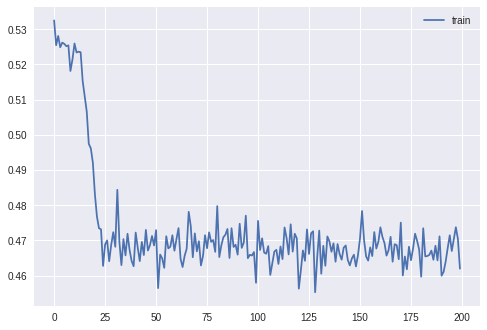

done training
100/100 [==============================] - 0s 4ms/step
[0.4676644504070282, 0.8031436800956726, 0.7502439022064209, 0.14829477667808533]
the accuracy for length 10 was: 80.31436314363144%
100/100 [==============================] - 0s 3ms/step
[0.47557684779167175, 0.8002710342407227, 0.7397561073303223, 0.15100136399269104]
the accuracy for length 20 was: 80.02710027100271%
100/100 [==============================] - 0s 3ms/step
[0.47057998180389404, 0.8024119138717651, 0.7407317161560059, 0.1492253690958023]
the accuracy for length 30 was: 80.24119241192412%
100/100 [==============================] - 0s 3ms/step
[0.4813690483570099, 0.798184335231781, 0.7319512367248535, 0.15298040211200714]
the accuracy for length 40 was: 79.81842818428184%
100/100 [==============================] - 0s 3ms/step
[0.4754076600074768, 0.8006775379180908, 0.7341463565826416, 0.15087386965751648]
the accuracy for length 50 was: 80.06775067750678%
100/100 [==============================] - 0s 

In [0]:
batch_size = 100
read_heads = 1
write_heads = 1
epochs = 200
verboose = 0
clipnorm = 10 
sameInit = RandomNormal(seed=0) # bias_initializer

lr = 0.01 # 5e-4   #0.001 was also good
#sgd = Adam(lr=lr, clipnorm=clipnorm, decay=0.5, amsgrad=True)
sgd = SGD(lr=lr, clipnorm=clipnorm, decay=0.5)


controller_input_dim, controller_output_dim = controller_input_output_shape(input_dim, output_dim, 20, 128, 3, read_heads,
            write_heads)
controller = Sequential()
controller.name="NTM_LSTM"
     
controller.add(LSTM(units=units,
                                kernel_initializer='random_normal', 
                                bias_initializer='random_normal',
                                activation='linear',
                                stateful=True,
                                implementation=1,   # best for gpu. other ones also might not work.
                                batch_input_shape=(batch_size, None, controller_input_dim)))
        
controller.add(Dense(units=controller_output_dim,
                                kernel_initializer=sameInit,
                                bias_initializer=sameInit,
                                activation='softmax'))
        
controller.compile(loss='binary_crossentropy', optimizer=sgd, metrics = ['binary_accuracy','categorical_accuracy','mse'], sample_weight_mode="temporal")
print(controller.summary())    
model_ntm_lstm = gen_model(input_dim=input_dim, output_dim=output_dim, batch_size=batch_size,
                                    controller_model=controller, read_heads=read_heads, write_heads=write_heads,
                                    activation="softmax")
print(model_ntm_lstm.summary())
print("model built, starting the copy experiment")

test_with_sequence_lengths(model_ntm_lstm, epochs=epochs, verboose=verboose)

##  Running NTM with Feedforward
Here we will create a **Feedforward-NTM** model with the hyper-parameters specified below as well as the chart in the **Report** section under the **Hyper-parameter Values**. We will train the model for $200$ epochs. We then test our model on a sequence of different length of inputs. The result of which will be used in the **Report** section under **Generalization of The Model to Longer Sequences**.

Tensor("neural_turing_machine_2/mul_10:0", shape=(100, 128, 20), dtype=float32)
Tensor("neural_turing_machine_2/while/mul_8:0", shape=(100, 128, 20), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_turing_machine_2 (Neu (None, None, 9)           13201     
Total params: 13,201
Trainable params: 13,201
Non-trainable params: 0
_________________________________________________________________
None
model built, starting the copy experiment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=10, epochs=200, callbacks=[<keras.ca..., workers=1, max_queue_size=10)`


Epoch 1/200
10/10 [==============================] - 3s 341ms/step - loss: 0.5256 - binary_accuracy: 0.8039 - categorical_accuracy: 0.0635 - mean_squared_error: 0.1649
Epoch 2/200
10/10 [==============================] - 3s 304ms/step - loss: 0.5252 - binary_accuracy: 0.8041 - categorical_accuracy: 0.0629 - mean_squared_error: 0.1647
Epoch 3/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5249 - binary_accuracy: 0.8042 - categorical_accuracy: 0.0630 - mean_squared_error: 0.1646
Epoch 4/200
10/10 [==============================] - 3s 299ms/step - loss: 0.5284 - binary_accuracy: 0.8025 - categorical_accuracy: 0.0636 - mean_squared_error: 0.1659
Epoch 5/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5232 - binary_accuracy: 0.8050 - categorical_accuracy: 0.0641 - mean_squared_error: 0.1640
Epoch 6/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5237 - binary_accuracy: 0.8048 - categorical_accuracy: 0.0639 - mean_squared_error:

Epoch 11/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5246 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7460 - mean_squared_error: 0.1645
Epoch 12/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5343 - binary_accuracy: 0.7996 - categorical_accuracy: 0.7365 - mean_squared_error: 0.1682
Epoch 13/200
10/10 [==============================] - 3s 305ms/step - loss: 0.5247 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1646
Epoch 14/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5248 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7467 - mean_squared_error: 0.1646
Epoch 15/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5308 - binary_accuracy: 0.8013 - categorical_accuracy: 0.7388 - mean_squared_error: 0.1668
Epoch 16/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5279 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7403 - mean_squared_

10/10 [==============================] - 3s 300ms/step - loss: 0.5254 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7451 - mean_squared_error: 0.1648
Epoch 21/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5257 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7430 - mean_squared_error: 0.1650
Epoch 22/200
10/10 [==============================] - 3s 299ms/step - loss: 0.5275 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7423 - mean_squared_error: 0.1657
Epoch 23/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5244 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7460 - mean_squared_error: 0.1645
Epoch 24/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5212 - binary_accuracy: 0.8058 - categorical_accuracy: 0.7492 - mean_squared_error: 0.1633
Epoch 25/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5253 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1648

10/10 [==============================] - 3s 300ms/step - loss: 0.5221 - binary_accuracy: 0.8054 - categorical_accuracy: 0.7505 - mean_squared_error: 0.1636
Epoch 30/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5214 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7496 - mean_squared_error: 0.1634
Epoch 31/200
10/10 [==============================] - 3s 299ms/step - loss: 0.5239 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1643
Epoch 32/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5286 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7420 - mean_squared_error: 0.1661
Epoch 33/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5298 - binary_accuracy: 0.8016 - categorical_accuracy: 0.7385 - mean_squared_error: 0.1665
Epoch 34/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5242 - binary_accuracy: 0.8043 - categorical_accuracy: 0.7426 - mean_squared_error: 0.1644

Epoch 39/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5268 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7445 - mean_squared_error: 0.1655
Epoch 40/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5272 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1656
Epoch 41/200
10/10 [==============================] - 3s 305ms/step - loss: 0.5263 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7427 - mean_squared_error: 0.1653
Epoch 42/200
10/10 [==============================] - 3s 305ms/step - loss: 0.5293 - binary_accuracy: 0.8018 - categorical_accuracy: 0.7398 - mean_squared_error: 0.1664
Epoch 43/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5291 - binary_accuracy: 0.8018 - categorical_accuracy: 0.7391 - mean_squared_error: 0.1663
Epoch 44/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5226 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7457 - mean_squared_

10/10 [==============================] - 3s 304ms/step - loss: 0.5272 - binary_accuracy: 0.8026 - categorical_accuracy: 0.7428 - mean_squared_error: 0.1657
Epoch 49/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5228 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7472 - mean_squared_error: 0.1640
Epoch 50/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5254 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7435 - mean_squared_error: 0.1650
Epoch 51/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5277 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7409 - mean_squared_error: 0.1659
Epoch 52/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5246 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7425 - mean_squared_error: 0.1647
Epoch 53/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5324 - binary_accuracy: 0.8000 - categorical_accuracy: 0.7342 - mean_squared_error: 0.1676

10/10 [==============================] - 3s 301ms/step - loss: 0.5191 - binary_accuracy: 0.8063 - categorical_accuracy: 0.7537 - mean_squared_error: 0.1627
Epoch 58/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5255 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7439 - mean_squared_error: 0.1651
Epoch 59/200
10/10 [==============================] - 3s 307ms/step - loss: 0.5264 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7428 - mean_squared_error: 0.1655
Epoch 60/200
10/10 [==============================] - 3s 297ms/step - loss: 0.5266 - binary_accuracy: 0.8026 - categorical_accuracy: 0.7420 - mean_squared_error: 0.1656
Epoch 61/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5195 - binary_accuracy: 0.8059 - categorical_accuracy: 0.7509 - mean_squared_error: 0.1629
Epoch 62/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5270 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7409 - mean_squared_error: 0.1657

Epoch 67/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5222 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7472 - mean_squared_error: 0.1640
Epoch 68/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5256 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1653
Epoch 69/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5234 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7432 - mean_squared_error: 0.1645
Epoch 70/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5247 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7430 - mean_squared_error: 0.1650
Epoch 71/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5231 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7466 - mean_squared_error: 0.1644
Epoch 72/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5279 - binary_accuracy: 0.8014 - categorical_accuracy: 0.7392 - mean_squared_

10/10 [==============================] - 3s 302ms/step - loss: 0.5232 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7435 - mean_squared_error: 0.1646
Epoch 77/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5207 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7478 - mean_squared_error: 0.1637
Epoch 78/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5243 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7413 - mean_squared_error: 0.1650
Epoch 79/200
10/10 [==============================] - 3s 304ms/step - loss: 0.5177 - binary_accuracy: 0.8058 - categorical_accuracy: 0.7517 - mean_squared_error: 0.1626
Epoch 80/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5215 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7464 - mean_squared_error: 0.1640
Epoch 81/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5238 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7403 - mean_squared_error: 0.1649

10/10 [==============================] - 3s 301ms/step - loss: 0.5246 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7381 - mean_squared_error: 0.1654
Epoch 86/200
10/10 [==============================] - 3s 305ms/step - loss: 0.5165 - binary_accuracy: 0.8056 - categorical_accuracy: 0.7488 - mean_squared_error: 0.1624
Epoch 87/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5238 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1652
Epoch 88/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5152 - binary_accuracy: 0.8060 - categorical_accuracy: 0.7498 - mean_squared_error: 0.1620
Epoch 89/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5234 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7399 - mean_squared_error: 0.1651
Epoch 90/200
10/10 [==============================] - 3s 299ms/step - loss: 0.5201 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7432 - mean_squared_error: 0.1639

Epoch 95/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5173 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7445 - mean_squared_error: 0.1632
Epoch 96/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5184 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7441 - mean_squared_error: 0.1636
Epoch 97/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5215 - binary_accuracy: 0.8015 - categorical_accuracy: 0.7389 - mean_squared_error: 0.1649
Epoch 98/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5169 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7431 - mean_squared_error: 0.1632
Epoch 99/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5132 - binary_accuracy: 0.8051 - categorical_accuracy: 0.7474 - mean_squared_error: 0.1619
Epoch 100/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5200 - binary_accuracy: 0.8016 - categorical_accuracy: 0.7416 - mean_squared

10/10 [==============================] - 3s 300ms/step - loss: 0.5137 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7472 - mean_squared_error: 0.1624
Epoch 105/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5097 - binary_accuracy: 0.8053 - categorical_accuracy: 0.7480 - mean_squared_error: 0.1610
Epoch 106/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5135 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7431 - mean_squared_error: 0.1625
Epoch 107/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5120 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7452 - mean_squared_error: 0.1620
Epoch 108/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5150 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7369 - mean_squared_error: 0.1632
Epoch 109/200
10/10 [==============================] - 3s 301ms/step - loss: 0.5103 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7465 - mean_squared_error: 0

10/10 [==============================] - 3s 302ms/step - loss: 0.5121 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7392 - mean_squared_error: 0.1625
Epoch 114/200
10/10 [==============================] - 3s 304ms/step - loss: 0.5112 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7397 - mean_squared_error: 0.1623
Epoch 115/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5103 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7397 - mean_squared_error: 0.1620
Epoch 116/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5045 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7470 - mean_squared_error: 0.1600
Epoch 117/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5098 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7387 - mean_squared_error: 0.1620
Epoch 118/200
10/10 [==============================] - 3s 300ms/step - loss: 0.5071 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7428 - mean_squared_error: 0

Epoch 123/200
10/10 [==============================] - 3s 298ms/step - loss: 0.4961 - binary_accuracy: 0.8063 - categorical_accuracy: 0.7503 - mean_squared_error: 0.1574
Epoch 124/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4977 - binary_accuracy: 0.8052 - categorical_accuracy: 0.7505 - mean_squared_error: 0.1581
Epoch 125/200
10/10 [==============================] - 3s 303ms/step - loss: 0.5023 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7418 - mean_squared_error: 0.1598
Epoch 126/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4909 - binary_accuracy: 0.8077 - categorical_accuracy: 0.7555 - mean_squared_error: 0.1558
Epoch 127/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4954 - binary_accuracy: 0.8053 - categorical_accuracy: 0.7489 - mean_squared_error: 0.1575
Epoch 128/200
10/10 [==============================] - 3s 304ms/step - loss: 0.4911 - binary_accuracy: 0.8070 - categorical_accuracy: 0.7520 - mean_sq

10/10 [==============================] - 3s 302ms/step - loss: 0.4960 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7440 - mean_squared_error: 0.1580
Epoch 133/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4955 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7437 - mean_squared_error: 0.1579
Epoch 134/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4988 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7391 - mean_squared_error: 0.1591
Epoch 135/200
10/10 [==============================] - 3s 302ms/step - loss: 0.5026 - binary_accuracy: 0.7999 - categorical_accuracy: 0.7331 - mean_squared_error: 0.1605
Epoch 136/200
10/10 [==============================] - 3s 297ms/step - loss: 0.4894 - binary_accuracy: 0.8055 - categorical_accuracy: 0.7492 - mean_squared_error: 0.1558
Epoch 137/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4904 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7448 - mean_squared_error: 0

10/10 [==============================] - 3s 302ms/step - loss: 0.4929 - binary_accuracy: 0.8028 - categorical_accuracy: 0.7415 - mean_squared_error: 0.1572
Epoch 142/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4846 - binary_accuracy: 0.8061 - categorical_accuracy: 0.7518 - mean_squared_error: 0.1543
Epoch 143/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4957 - binary_accuracy: 0.8011 - categorical_accuracy: 0.7363 - mean_squared_error: 0.1583
Epoch 144/200
10/10 [==============================] - 3s 303ms/step - loss: 0.4846 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7495 - mean_squared_error: 0.1543
Epoch 145/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4956 - binary_accuracy: 0.8007 - categorical_accuracy: 0.7359 - mean_squared_error: 0.1583
Epoch 146/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4895 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7430 - mean_squared_error: 0

Epoch 151/200
10/10 [==============================] - 3s 303ms/step - loss: 0.4842 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7463 - mean_squared_error: 0.1544
Epoch 152/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4862 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1551
Epoch 153/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4828 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7462 - mean_squared_error: 0.1539
Epoch 154/200
10/10 [==============================] - 3s 299ms/step - loss: 0.4856 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7444 - mean_squared_error: 0.1549
Epoch 155/200
10/10 [==============================] - 3s 305ms/step - loss: 0.4834 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7450 - mean_squared_error: 0.1541
Epoch 156/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4880 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7406 - mean_sq

10/10 [==============================] - 3s 302ms/step - loss: 0.4818 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7454 - mean_squared_error: 0.1536
Epoch 161/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4826 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1539
Epoch 162/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4869 - binary_accuracy: 0.8017 - categorical_accuracy: 0.7402 - mean_squared_error: 0.1554
Epoch 163/200
10/10 [==============================] - 3s 307ms/step - loss: 0.4770 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7498 - mean_squared_error: 0.1520
Epoch 164/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4812 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1534
Epoch 165/200
10/10 [==============================] - 3s 304ms/step - loss: 0.4760 - binary_accuracy: 0.8059 - categorical_accuracy: 0.7510 - mean_squared_error: 0

10/10 [==============================] - 3s 302ms/step - loss: 0.4760 - binary_accuracy: 0.8054 - categorical_accuracy: 0.7497 - mean_squared_error: 0.1516
Epoch 170/200
10/10 [==============================] - 3s 299ms/step - loss: 0.4812 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7424 - mean_squared_error: 0.1534
Epoch 171/200
10/10 [==============================] - 3s 303ms/step - loss: 0.4791 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7443 - mean_squared_error: 0.1527
Epoch 172/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4707 - binary_accuracy: 0.8073 - categorical_accuracy: 0.7531 - mean_squared_error: 0.1498
Epoch 173/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4793 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1528
Epoch 174/200
10/10 [==============================] - 3s 299ms/step - loss: 0.4829 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7397 - mean_squared_error: 0

Epoch 179/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4809 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7404 - mean_squared_error: 0.1533
Epoch 180/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4783 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7442 - mean_squared_error: 0.1525
Epoch 181/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4770 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7447 - mean_squared_error: 0.1520
Epoch 182/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4735 - binary_accuracy: 0.8052 - categorical_accuracy: 0.7500 - mean_squared_error: 0.1508
Epoch 183/200
10/10 [==============================] - 3s 299ms/step - loss: 0.4754 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7468 - mean_squared_error: 0.1514
Epoch 184/200
10/10 [==============================] - 3s 301ms/step - loss: 0.4744 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7475 - mean_sq

10/10 [==============================] - 3s 300ms/step - loss: 0.4835 - binary_accuracy: 0.8008 - categorical_accuracy: 0.7355 - mean_squared_error: 0.1542
Epoch 189/200
10/10 [==============================] - 3s 299ms/step - loss: 0.4680 - binary_accuracy: 0.8070 - categorical_accuracy: 0.7543 - mean_squared_error: 0.1488
Epoch 190/200
10/10 [==============================] - 3s 302ms/step - loss: 0.4769 - binary_accuracy: 0.8033 - categorical_accuracy: 0.7440 - mean_squared_error: 0.1519
Epoch 191/200
10/10 [==============================] - 3s 304ms/step - loss: 0.4797 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7397 - mean_squared_error: 0.1529
Epoch 192/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4756 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1515
Epoch 193/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4726 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7471 - mean_squared_error: 0

10/10 [==============================] - 3s 302ms/step - loss: 0.4840 - binary_accuracy: 0.8000 - categorical_accuracy: 0.7351 - mean_squared_error: 0.1544
Epoch 198/200
10/10 [==============================] - 3s 305ms/step - loss: 0.4743 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7464 - mean_squared_error: 0.1510
Epoch 199/200
10/10 [==============================] - 3s 300ms/step - loss: 0.4772 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7415 - mean_squared_error: 0.1520
Epoch 200/200
10/10 [==============================] - 3s 305ms/step - loss: 0.4702 - binary_accuracy: 0.8054 - categorical_accuracy: 0.7502 - mean_squared_error: 0.1496


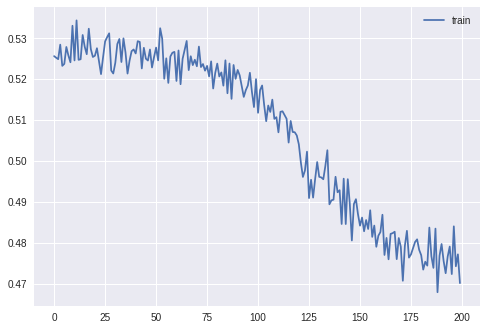

done training
100/100 [==============================] - 0s 3ms/step
[0.48443305492401123, 0.7999187111854553, 0.7297561168670654, 0.1544853001832962]
the accuracy for length 10 was: 79.9918699186992%
100/100 [==============================] - 0s 1ms/step
[0.45721930265426636, 0.810569167137146, 0.7651219367980957, 0.14502696692943573]
the accuracy for length 20 was: 81.0569105691057%
100/100 [==============================] - 0s 1ms/step
[0.4843052923679352, 0.7998916506767273, 0.7317073345184326, 0.15446029603481293]
the accuracy for length 30 was: 79.98915989159892%
100/100 [==============================] - 0s 1ms/step
[0.46028557419776917, 0.8093224763870239, 0.761951208114624, 0.1461029052734375]
the accuracy for length 40 was: 80.93224932249322%
100/100 [==============================] - 0s 1ms/step
[0.4692862629890442, 0.805691123008728, 0.752439022064209, 0.14925652742385864]
the accuracy for length 50 was: 80.5691056910569%
100/100 [==============================] - 0s 1ms/st

In [0]:
batch_size = 100
read_heads = 1
write_heads = 1
epochs = 200
verboose = 0
clipnorm = 10  
sameInit = RandomNormal(seed=0) # bias_initializer

lr = 0.01 # 5e-4   #0.001 was good
#sgd = Adam(lr=lr, clipnorm=clipnorm, decay=0.5, amsgrad=True)
sgd = SGD(lr=lr, clipnorm=clipnorm, decay=0.5)

controller_input_dim, controller_output_dim = controller_input_output_shape(input_dim, output_dim, 20, 128, 3, read_heads,
            write_heads)

controller = Sequential()
controller.name= "feedforward"
    
controller.add(Dense(units=units,
                                kernel_initializer=sameInit,
                                bias_initializer=sameInit,
                                activation='softmax',
                                input_dim=controller_input_dim))
        
controller.add(Dense(units=controller_output_dim,
                                kernel_initializer=sameInit,
                                bias_initializer=sameInit,
                                activation='softmax'))
    
        
controller.compile(loss='binary_crossentropy', optimizer=sgd, metrics = ['binary_accuracy','categorical_accuracy','mse'], sample_weight_mode="temporal")
model_ntm_feedforward = gen_model(input_dim=input_dim, output_dim=output_dim, batch_size=batch_size,
                                    controller_model=controller, read_heads=read_heads, write_heads=write_heads,
                                    activation="softmax")

print(model_ntm_feedforward.summary())
print("model built, starting the copy experiment")
test_with_sequence_lengths(model_ntm_feedforward, epochs=epochs, verboose=verboose)



##  Running LSTM
Here we will create a vanilla **LSTM** model with the hyper-parameters specified below as well as the chart in the **Report** section under the **Hyper-parameter Values**. We will train the model for $200$ epochs. We then test our model on a sequence of different length of inputs. The result of which will be used in the **Report** section under **Generalization of The Model to Longer Sequences**.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 100)         44000     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 9)           3960      
_________________________________________________________________
activation_1 (Activation)    (None, None, 9)           0         
Total params: 47,960
Trainable params: 47,960
Non-trainable params: 0
_________________________________________________________________
None
model built, starting the copy experiment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=10, epochs=200, callbacks=[<keras.ca..., workers=1, max_queue_size=10)`


Epoch 1/200
10/10 [==============================] - 3s 280ms/step - loss: 3.7648 - binary_accuracy: 0.8058 - categorical_accuracy: 0.5268 - mean_squared_error: 0.1613
Epoch 2/200
10/10 [==============================] - 2s 225ms/step - loss: 3.7514 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7434 - mean_squared_error: 0.1612
Epoch 3/200
10/10 [==============================] - 2s 227ms/step - loss: 3.6955 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7466 - mean_squared_error: 0.1591
Epoch 4/200
10/10 [==============================] - 2s 226ms/step - loss: 3.6772 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7470 - mean_squared_error: 0.1584
Epoch 5/200
10/10 [==============================] - 2s 226ms/step - loss: 3.6968 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7417 - mean_squared_error: 0.1591
Epoch 6/200
10/10 [==============================] - 2s 227ms/step - loss: 3.6733 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7444 - mean_squared_error:

Epoch 10/200
10/10 [==============================] - 2s 227ms/step - loss: 3.6888 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7408 - mean_squared_error: 0.1587
Epoch 11/200
10/10 [==============================] - 2s 228ms/step - loss: 3.6767 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7411 - mean_squared_error: 0.1582
Epoch 12/200
10/10 [==============================] - 2s 229ms/step - loss: 3.7072 - binary_accuracy: 0.8011 - categorical_accuracy: 0.7383 - mean_squared_error: 0.1593
Epoch 13/200
10/10 [==============================] - 2s 228ms/step - loss: 3.7567 - binary_accuracy: 0.7989 - categorical_accuracy: 0.7290 - mean_squared_error: 0.1612
Epoch 14/200
10/10 [==============================] - 2s 226ms/step - loss: 3.6415 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7438 - mean_squared_error: 0.1568
Epoch 15/200
10/10 [==============================] - 2s 225ms/step - loss: 3.6192 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7467 - mean_squared_

10/10 [==============================] - 2s 227ms/step - loss: 3.6458 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7422 - mean_squared_error: 0.1568
Epoch 20/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5783 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7495 - mean_squared_error: 0.1542
Epoch 21/200
10/10 [==============================] - 2s 228ms/step - loss: 3.6248 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7440 - mean_squared_error: 0.1560
Epoch 22/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5894 - binary_accuracy: 0.8050 - categorical_accuracy: 0.7493 - mean_squared_error: 0.1546
Epoch 23/200
10/10 [==============================] - 2s 226ms/step - loss: 3.6418 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7416 - mean_squared_error: 0.1566
Epoch 24/200
10/10 [==============================] - 2s 230ms/step - loss: 3.6445 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7412 - mean_squared_error: 0.1567

10/10 [==============================] - 2s 228ms/step - loss: 3.6307 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7400 - mean_squared_error: 0.1561
Epoch 29/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5726 - binary_accuracy: 0.8052 - categorical_accuracy: 0.7495 - mean_squared_error: 0.1539
Epoch 30/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5062 - binary_accuracy: 0.8081 - categorical_accuracy: 0.7540 - mean_squared_error: 0.1513
Epoch 31/200
10/10 [==============================] - 2s 226ms/step - loss: 3.6120 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7431 - mean_squared_error: 0.1553
Epoch 32/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5746 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7473 - mean_squared_error: 0.1539
Epoch 33/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5982 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7447 - mean_squared_error: 0.1548

Epoch 38/200
10/10 [==============================] - 2s 225ms/step - loss: 3.6371 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7390 - mean_squared_error: 0.1562
Epoch 39/200
10/10 [==============================] - 2s 225ms/step - loss: 3.6352 - binary_accuracy: 0.8018 - categorical_accuracy: 0.7393 - mean_squared_error: 0.1561
Epoch 40/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5967 - binary_accuracy: 0.8033 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1546
Epoch 41/200
10/10 [==============================] - 2s 222ms/step - loss: 3.5606 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7481 - mean_squared_error: 0.1532
Epoch 42/200
10/10 [==============================] - 2s 224ms/step - loss: 3.6319 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7379 - mean_squared_error: 0.1560
Epoch 43/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5767 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7442 - mean_squared_

10/10 [==============================] - 2s 228ms/step - loss: 3.5852 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7433 - mean_squared_error: 0.1541
Epoch 48/200
10/10 [==============================] - 2s 229ms/step - loss: 3.6002 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7409 - mean_squared_error: 0.1547
Epoch 49/200
10/10 [==============================] - 2s 227ms/step - loss: 3.6802 - binary_accuracy: 0.7994 - categorical_accuracy: 0.7330 - mean_squared_error: 0.1577
Epoch 50/200
10/10 [==============================] - 2s 229ms/step - loss: 3.5915 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7441 - mean_squared_error: 0.1543
Epoch 51/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5691 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7452 - mean_squared_error: 0.1535
Epoch 52/200
10/10 [==============================] - 2s 229ms/step - loss: 3.5726 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7441 - mean_squared_error: 0.1536

10/10 [==============================] - 2s 225ms/step - loss: 3.5903 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7430 - mean_squared_error: 0.1543
Epoch 57/200
10/10 [==============================] - 2s 229ms/step - loss: 3.5437 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7474 - mean_squared_error: 0.1525
Epoch 58/200
10/10 [==============================] - 2s 225ms/step - loss: 3.6006 - binary_accuracy: 0.8024 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1546
Epoch 59/200
10/10 [==============================] - 2s 220ms/step - loss: 3.5058 - binary_accuracy: 0.8062 - categorical_accuracy: 0.7518 - mean_squared_error: 0.1510
Epoch 60/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5291 - binary_accuracy: 0.8052 - categorical_accuracy: 0.7483 - mean_squared_error: 0.1519
Epoch 61/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5638 - binary_accuracy: 0.8038 - categorical_accuracy: 0.7424 - mean_squared_error: 0.1532

Epoch 66/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5538 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7457 - mean_squared_error: 0.1528
Epoch 67/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5900 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7399 - mean_squared_error: 0.1542
Epoch 68/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5360 - binary_accuracy: 0.8049 - categorical_accuracy: 0.7447 - mean_squared_error: 0.1521
Epoch 69/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5625 - binary_accuracy: 0.8034 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1531
Epoch 70/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5343 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7459 - mean_squared_error: 0.1520
Epoch 71/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5203 - binary_accuracy: 0.8053 - categorical_accuracy: 0.7487 - mean_squared_

10/10 [==============================] - 2s 227ms/step - loss: 3.5804 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7424 - mean_squared_error: 0.1537
Epoch 76/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5309 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1518
Epoch 77/200
10/10 [==============================] - 2s 225ms/step - loss: 3.6029 - binary_accuracy: 0.8015 - categorical_accuracy: 0.7376 - mean_squared_error: 0.1546
Epoch 78/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5297 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7450 - mean_squared_error: 0.1518
Epoch 79/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5273 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7465 - mean_squared_error: 0.1517
Epoch 80/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5446 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7454 - mean_squared_error: 0.1523

10/10 [==============================] - 2s 224ms/step - loss: 3.5115 - binary_accuracy: 0.8051 - categorical_accuracy: 0.7471 - mean_squared_error: 0.1511
Epoch 85/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5160 - binary_accuracy: 0.8048 - categorical_accuracy: 0.7472 - mean_squared_error: 0.1512
Epoch 86/200
10/10 [==============================] - 2s 223ms/step - loss: 3.5439 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7433 - mean_squared_error: 0.1523
Epoch 87/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5864 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7387 - mean_squared_error: 0.1539
Epoch 88/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5550 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7430 - mean_squared_error: 0.1527
Epoch 89/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5484 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7428 - mean_squared_error: 0.1524

Epoch 94/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5740 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7377 - mean_squared_error: 0.1534
Epoch 95/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5548 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7433 - mean_squared_error: 0.1527
Epoch 96/200
10/10 [==============================] - 2s 228ms/step - loss: 3.5727 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7421 - mean_squared_error: 0.1533
Epoch 97/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5625 - binary_accuracy: 0.8026 - categorical_accuracy: 0.7410 - mean_squared_error: 0.1529
Epoch 98/200
10/10 [==============================] - 2s 225ms/step - loss: 3.6313 - binary_accuracy: 0.7995 - categorical_accuracy: 0.7349 - mean_squared_error: 0.1556
Epoch 99/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5794 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7397 - mean_squared_

10/10 [==============================] - 2s 224ms/step - loss: 3.5237 - binary_accuracy: 0.8039 - categorical_accuracy: 0.7459 - mean_squared_error: 0.1514
Epoch 104/200
10/10 [==============================] - 2s 228ms/step - loss: 3.4952 - binary_accuracy: 0.8052 - categorical_accuracy: 0.7492 - mean_squared_error: 0.1503
Epoch 105/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5889 - binary_accuracy: 0.8011 - categorical_accuracy: 0.7390 - mean_squared_error: 0.1539
Epoch 106/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5861 - binary_accuracy: 0.8015 - categorical_accuracy: 0.7349 - mean_squared_error: 0.1538
Epoch 107/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5227 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1514
Epoch 108/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5720 - binary_accuracy: 0.8017 - categorical_accuracy: 0.7394 - mean_squared_error: 0

10/10 [==============================] - 2s 226ms/step - loss: 3.5706 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7388 - mean_squared_error: 0.1532
Epoch 113/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5584 - binary_accuracy: 0.8023 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1527
Epoch 114/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5113 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7450 - mean_squared_error: 0.1509
Epoch 115/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5001 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7471 - mean_squared_error: 0.1505
Epoch 116/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5070 - binary_accuracy: 0.8044 - categorical_accuracy: 0.7452 - mean_squared_error: 0.1507
Epoch 117/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5426 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7428 - mean_squared_error: 0

Epoch 122/200
10/10 [==============================] - 2s 222ms/step - loss: 3.5124 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7429 - mean_squared_error: 0.1509
Epoch 123/200
10/10 [==============================] - 2s 226ms/step - loss: 3.4986 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7469 - mean_squared_error: 0.1504
Epoch 124/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5136 - binary_accuracy: 0.8040 - categorical_accuracy: 0.7433 - mean_squared_error: 0.1510
Epoch 125/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5189 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7432 - mean_squared_error: 0.1511
Epoch 126/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5462 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7424 - mean_squared_error: 0.1522
Epoch 127/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5471 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7413 - mean_sq

10/10 [==============================] - 2s 226ms/step - loss: 3.5328 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7405 - mean_squared_error: 0.1517
Epoch 132/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5291 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7424 - mean_squared_error: 0.1515
Epoch 133/200
10/10 [==============================] - 2s 226ms/step - loss: 3.4772 - binary_accuracy: 0.8051 - categorical_accuracy: 0.7479 - mean_squared_error: 0.1495
Epoch 134/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5444 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7401 - mean_squared_error: 0.1521
Epoch 135/200
10/10 [==============================] - 2s 228ms/step - loss: 3.4895 - binary_accuracy: 0.8045 - categorical_accuracy: 0.7462 - mean_squared_error: 0.1500
Epoch 136/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5377 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7416 - mean_squared_error: 0

10/10 [==============================] - 2s 226ms/step - loss: 3.5096 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7438 - mean_squared_error: 0.1507
Epoch 141/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5107 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7435 - mean_squared_error: 0.1508
Epoch 142/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5794 - binary_accuracy: 0.8009 - categorical_accuracy: 0.7363 - mean_squared_error: 0.1534
Epoch 143/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5197 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7421 - mean_squared_error: 0.1511
Epoch 144/200
10/10 [==============================] - 2s 223ms/step - loss: 3.4217 - binary_accuracy: 0.8070 - categorical_accuracy: 0.7534 - mean_squared_error: 0.1473
Epoch 145/200
10/10 [==============================] - 2s 229ms/step - loss: 3.5788 - binary_accuracy: 0.8006 - categorical_accuracy: 0.7354 - mean_squared_error: 0

Epoch 150/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5382 - binary_accuracy: 0.8026 - categorical_accuracy: 0.7376 - mean_squared_error: 0.1518
Epoch 151/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5185 - binary_accuracy: 0.8030 - categorical_accuracy: 0.7415 - mean_squared_error: 0.1510
Epoch 152/200
10/10 [==============================] - 2s 223ms/step - loss: 3.5504 - binary_accuracy: 0.8022 - categorical_accuracy: 0.7396 - mean_squared_error: 0.1523
Epoch 153/200
10/10 [==============================] - 2s 226ms/step - loss: 3.4525 - binary_accuracy: 0.8056 - categorical_accuracy: 0.7498 - mean_squared_error: 0.1485
Epoch 154/200
10/10 [==============================] - 2s 224ms/step - loss: 3.4630 - binary_accuracy: 0.8056 - categorical_accuracy: 0.7478 - mean_squared_error: 0.1488
Epoch 155/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5458 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7374 - mean_sq

10/10 [==============================] - 2s 227ms/step - loss: 3.5597 - binary_accuracy: 0.8012 - categorical_accuracy: 0.7357 - mean_squared_error: 0.1526
Epoch 160/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5353 - binary_accuracy: 0.8020 - categorical_accuracy: 0.7398 - mean_squared_error: 0.1516
Epoch 161/200
10/10 [==============================] - 2s 226ms/step - loss: 3.4880 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7452 - mean_squared_error: 0.1498
Epoch 162/200
10/10 [==============================] - 2s 224ms/step - loss: 3.4512 - binary_accuracy: 0.8055 - categorical_accuracy: 0.7492 - mean_squared_error: 0.1484
Epoch 163/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5241 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7394 - mean_squared_error: 0.1512
Epoch 164/200
10/10 [==============================] - 2s 224ms/step - loss: 3.4767 - binary_accuracy: 0.8047 - categorical_accuracy: 0.7460 - mean_squared_error: 0

10/10 [==============================] - 2s 225ms/step - loss: 3.4841 - binary_accuracy: 0.8041 - categorical_accuracy: 0.7453 - mean_squared_error: 0.1496
Epoch 169/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5220 - binary_accuracy: 0.8025 - categorical_accuracy: 0.7402 - mean_squared_error: 0.1511
Epoch 170/200
10/10 [==============================] - 2s 223ms/step - loss: 3.5329 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7384 - mean_squared_error: 0.1515
Epoch 171/200
10/10 [==============================] - 2s 225ms/step - loss: 3.4989 - binary_accuracy: 0.8032 - categorical_accuracy: 0.7428 - mean_squared_error: 0.1502
Epoch 172/200
10/10 [==============================] - 2s 227ms/step - loss: 3.5126 - binary_accuracy: 0.8029 - categorical_accuracy: 0.7409 - mean_squared_error: 0.1507
Epoch 173/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5340 - binary_accuracy: 0.8019 - categorical_accuracy: 0.7397 - mean_squared_error: 0

Epoch 178/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5184 - binary_accuracy: 0.8027 - categorical_accuracy: 0.7394 - mean_squared_error: 0.1509
Epoch 179/200
10/10 [==============================] - 2s 225ms/step - loss: 3.5049 - binary_accuracy: 0.8031 - categorical_accuracy: 0.7423 - mean_squared_error: 0.1504
Epoch 180/200
10/10 [==============================] - 2s 228ms/step - loss: 3.4908 - binary_accuracy: 0.8035 - categorical_accuracy: 0.7440 - mean_squared_error: 0.1498
Epoch 181/200
10/10 [==============================] - 2s 227ms/step - loss: 3.4721 - binary_accuracy: 0.8042 - categorical_accuracy: 0.7449 - mean_squared_error: 0.1491
Epoch 182/200
10/10 [==============================] - 2s 226ms/step - loss: 3.4658 - binary_accuracy: 0.8046 - categorical_accuracy: 0.7466 - mean_squared_error: 0.1489
Epoch 183/200
10/10 [==============================] - 2s 229ms/step - loss: 3.5394 - binary_accuracy: 0.8017 - categorical_accuracy: 0.7370 - mean_sq

10/10 [==============================] - 2s 225ms/step - loss: 3.4508 - binary_accuracy: 0.8052 - categorical_accuracy: 0.7445 - mean_squared_error: 0.1483
Epoch 188/200
10/10 [==============================] - 2s 228ms/step - loss: 3.4379 - binary_accuracy: 0.8062 - categorical_accuracy: 0.7473 - mean_squared_error: 0.1477
Epoch 189/200
10/10 [==============================] - 2s 224ms/step - loss: 3.4463 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7481 - mean_squared_error: 0.1480
Epoch 190/200
10/10 [==============================] - 2s 224ms/step - loss: 3.4342 - binary_accuracy: 0.8057 - categorical_accuracy: 0.7490 - mean_squared_error: 0.1476
Epoch 191/200
10/10 [==============================] - 2s 225ms/step - loss: 3.4024 - binary_accuracy: 0.8071 - categorical_accuracy: 0.7525 - mean_squared_error: 0.1464
Epoch 192/200
10/10 [==============================] - 2s 223ms/step - loss: 3.4090 - binary_accuracy: 0.8070 - categorical_accuracy: 0.7526 - mean_squared_error: 0

10/10 [==============================] - 2s 226ms/step - loss: 3.4859 - binary_accuracy: 0.8037 - categorical_accuracy: 0.7403 - mean_squared_error: 0.1496
Epoch 197/200
10/10 [==============================] - 2s 226ms/step - loss: 3.4235 - binary_accuracy: 0.8062 - categorical_accuracy: 0.7493 - mean_squared_error: 0.1471
Epoch 198/200
10/10 [==============================] - 2s 226ms/step - loss: 3.5445 - binary_accuracy: 0.8010 - categorical_accuracy: 0.7349 - mean_squared_error: 0.1519
Epoch 199/200
10/10 [==============================] - 2s 224ms/step - loss: 3.5225 - binary_accuracy: 0.8021 - categorical_accuracy: 0.7365 - mean_squared_error: 0.1510
Epoch 200/200
10/10 [==============================] - 2s 225ms/step - loss: 3.4818 - binary_accuracy: 0.8036 - categorical_accuracy: 0.7404 - mean_squared_error: 0.1494


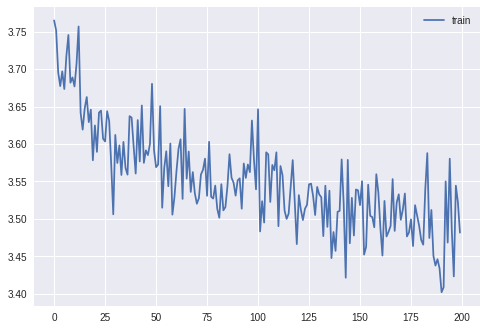

done training
100/100 [==============================] - 0s 4ms/step
[3.6384315490722656, 0.7969105839729309, 0.726097583770752, 0.15552771091461182]
the accuracy for length 10 was: 79.6910569105691%
100/100 [==============================] - 0s 556us/step
[3.4163522720336914, 0.8067209124565125, 0.7424390316009521, 0.14689578115940094]
the accuracy for length 20 was: 80.67208672086721%
100/100 [==============================] - 0s 568us/step
[3.5294976234436035, 0.8017615675926208, 0.7334146499633789, 0.15134131908416748]
the accuracy for length 30 was: 80.17615176151762%
100/100 [==============================] - 0s 663us/step
[3.4582035541534424, 0.8046070337295532, 0.7439024448394775, 0.14849230647087097]
the accuracy for length 40 was: 80.46070460704607%
100/100 [==============================] - 0s 637us/step
[3.3071625232696533, 0.8103252649307251, 0.7687804698944092, 0.14257843792438507]
the accuracy for length 50 was: 81.03252032520325%
100/100 [==============================]

In [0]:
# not bad : batch_size = 25    , lr = 5e-5 , sgd = 'adam', activation_func = 'softmax'  try this with 2000 epochs later.
# not bad : batch_size = 25    , lr = 5e-5 , sgd = 'adam', activation_func = 'softmax'    try this with 2000 epochs later.
# not bad : batch_size = 50 sgd = 'adam' activation_func = 'softmax'

batch_size = 100 
epochs = 200
verboose = 0
lr = 0.001 # 5e-4
clipnorm = 10  
activation_func = 'softmax' #'hard_sigmoid'

sameInit = RandomUniform(minval=0.8, maxval=0.99, seed=0) # bias_initializer

sgd = Adam(lr=lr, clipnorm=clipnorm, decay=0.5, amsgrad=True)
#sgd = SGD(lr=lr)
#sgd = 'adam'

loss='categorical_crossentropy'
model = gen_model_lstm(input_dim=input_dim, output_dim=output_dim, batch_size=batch_size, sgd=sgd, loss=loss)

print(model.summary())
print("model built, starting the copy experiment")
test_with_sequence_lengths(model, epochs=epochs, verboose=verboose)

##  Plot Generation For Further Analysis
In this section we are going to produce a few more graphs that we will us later on in the **Discussion** section. The loss data for these graphs comes from the sections called **Running NTM with LSTM**, **Running NTM with Feedforward**, and **Running LSTM**.

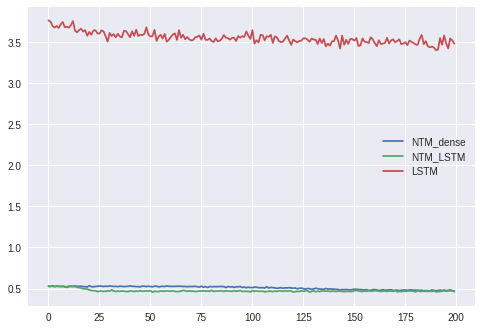

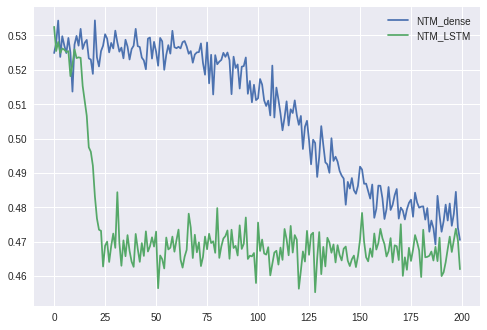

In [0]:
import matplotlib.pyplot as plt

LSTM_arr = np.loadtxt("loss_history_ntm_LSTM.txt",  delimiter=",")
NTM_feedforward_arr = np.loadtxt("loss_history_ntm_NTM_-_feedforward.txt",  delimiter=",")
NTM_LSTM_arr = np.loadtxt("loss_history_ntm_NTM_-_NTM_LSTM.txt",  delimiter=",")


plt.plot(NTM_feedforward_arr, label='NTM_feedforward')
plt.plot(NTM_LSTM_arr, label='NTM_LSTM')
plt.plot(LSTM_arr, label='LSTM')

plt.legend()
plt.show()


plt.plot(NTM_feedforward_arr, label='NTM_feedforward')
plt.plot(NTM_LSTM_arr, label='NTM_LSTM')

plt.legend()
plt.show()